In [1]:
## import dependecies
import os
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn as skl
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd
# import seaborn as sns
import tensorflow as tf

In [2]:
path = os.path.join(os.getcwd(), 'Resources', 'all_city_data.csv')
df = pd.read_csv(path)

In [3]:
df = df.drop(columns = {"Unnamed: 0"})
df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,dt
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,2013-01-03 00:00:00
1,9.0,9.0,3.0,17.0,300.0,89.0,-0.5,1024.5,-21.4,0.0,2013-01-03 00:00:00
2,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,2013-01-03 00:00:00
3,7.0,7.0,3.0,2.0,100.0,91.0,-2.3,1020.3,-20.7,0.0,2013-01-03 00:00:00
4,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,0.0,2013-01-03 00:00:00


In [4]:
df['dt'] = pd.to_datetime(df['dt'])

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PM2.5,367284.0,78.992137,78.607575,2.0000,21.0,55.0,110.0,844.0
PM10,367284.0,104.433660,89.908912,2.0000,37.0,83.0,145.0,999.0
SO2,367284.0,15.508788,21.368411,0.2856,2.0,7.0,19.0,500.0
NO2,367284.0,50.344687,34.745149,2.0000,23.0,43.0,70.0,290.0
CO,367284.0,1215.617411,1122.181647,100.0000,500.0,900.0,1500.0,10000.0
O3,367284.0,58.005149,57.421619,0.2142,10.0,45.0,83.0,1071.0
TEMP,367284.0,14.077551,11.285307,-19.9000,4.0,15.3,23.5,41.6
PRES,367284.0,1010.339889,10.328444,982.4000,1002.1,1009.8,1018.3,1042.8
DEWP,367284.0,3.120514,13.604614,-43.4000,-8.0,4.1,15.4,29.1
RAIN,367284.0,0.067670,0.840393,0.0000,0.0,0.0,0.0,72.5


In [6]:
# df = df.groupby(pd.Grouper(key='dt', axis=0, freq='h')).mean().dropna().reset_index()

In [7]:
# df_2 = df.groupby(pd.Grouper(key='dt', axis=0, freq='D')).mean().dropna().reset_index()

## Scale the Data

In [8]:
features = ["PM10", "SO2", "NO2", "CO", "O3", "TEMP", "PRES", "DEWP", "RAIN"]
scalar = StandardScaler()
# the fit_transform ops returns a 2d numpy.array, we cast it to a pd.DataFrame
standardized_features = pd.DataFrame(scalar.fit_transform(df[features].copy()), columns = features)
old_shape = df.shape
# drop the unnormalized features from the dataframe
df.drop(features, axis = 1, inplace = True)
# join back the normalized features
df = pd.concat([df, standardized_features], axis= 1)
assert old_shape == df.shape, "something went wrong!"

In [9]:
# features = ["PM10", "SO2", "NO2", "CO", "O3", "TEMP", "PRES", "DEWP", "RAIN"]
# scalar = StandardScaler()
# # the fit_transform ops returns a 2d numpy.array, we cast it to a pd.DataFrame
# standardized_features = pd.DataFrame(scalar.fit_transform(df_2[features].copy()), columns = features)
# old_shape = df_2.shape
# # drop the unnormalized features from the dataframe
# df_2.drop(features, axis = 1, inplace = True)
# # join back the normalized features
# df_2 = pd.concat([df_2, standardized_features], axis= 1)
# assert old_shape == df_2.shape, "something went wrong!"

In [10]:
df.head()

,PM2.5,dt,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN
0,4.0,2013-01-03,-1.117062,-0.538590,-1.247505,-0.815927,0.330797,-1.309452,1.225754,-1.611258,-0.080522
1,9.0,2013-01-03,-1.061450,-0.585388,-0.959695,-0.815927,0.539777,-1.291730,1.370984,-1.802370,-0.080522
2,4.0,2013-01-03,-1.117062,-0.070608,-0.873352,-0.815927,0.191476,-1.309452,1.225754,-1.611258,-0.080522
3,7.0,2013-01-03,-1.083694,-0.585388,-1.391410,-0.994152,0.574608,-1.451230,0.964339,-1.750917,-0.080522
4,5.0,2013-01-03,-1.005838,-0.538590,-1.103600,-0.905040,0.470117,-1.291730,1.370984,-1.802370,-0.080522


In [11]:
# df_2.head()

(-1.0, 1.0)

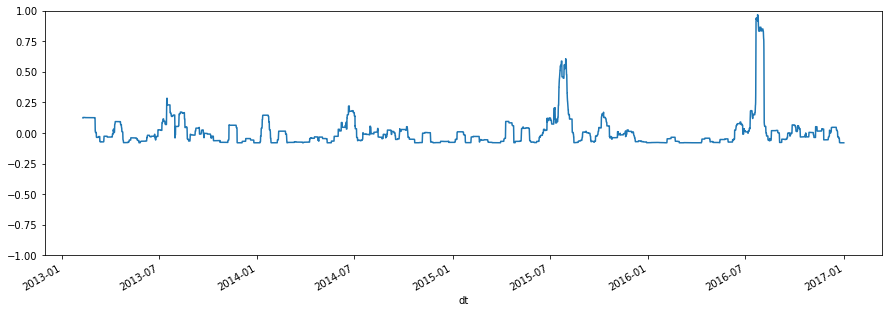

In [12]:
import matplotlib.pyplot as plt
df.groupby('dt').mean()['RAIN'].rolling(365).mean().plot(figsize=(15, 5))
plt.ylim(-1, 1)

## Create Machine Learning Model for PM2.5

In [13]:
time_index=pd.to_datetime(df['dt'])
df_kl=df.set_index(time_index)
df_kl.index

DatetimeIndex(['2013-01-03 00:00:00', '2013-01-03 00:00:00',
               '2013-01-03 00:00:00', '2013-01-03 00:00:00',
               '2013-01-03 00:00:00', '2013-01-03 00:00:00',
               '2013-01-03 00:00:00', '2013-01-03 00:00:00',
               '2013-01-03 00:00:00', '2013-01-03 00:00:00',
               ...
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='dt', length=367284, freq=None)

In [14]:
df_kl=df.drop('dt', axis=1)
y = df_kl['PM2.5']
X = df_kl.drop(columns= ['PM2.5'])
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=False)

In [15]:
y.isna().sum()

0

In [16]:
X.isna().sum()

PM10    0
SO2     0
NO2     0
CO      0
O3      0
TEMP    0
PRES    0
DEWP    0
RAIN    0
dtype: int64

In [17]:
model=tf.keras.models.Sequential()
layer_1=tf.keras.layers.Dense(units=48, activation="relu", input_dim=9)
model.add(layer_1)
layer_2=tf.keras.layers.Dense(units=32, activation="relu", input_dim=9)
model.add(layer_2)
layer_2=tf.keras.layers.Dense(units=32, activation="relu", input_dim=9)
model.add(layer_2)
# layer_3=tf.keras.layers.Dense(units=1, activation="sigmoid", input_dim=9)
# model.add(layer_3)
output_layer=tf.keras.layers.Dense(units=1)
model.add(output_layer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 48)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1568      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 3,137
Trainable params: 3,137
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
model.fit(X_train, y_train, epochs=15)

Epoch 1/15
8609/8609 [==============================] - 16s 2ms/step - loss: 828.7184 - mean_squared_error: 828.7184 0s - loss: 838.6893 - mean
Epoch 2/15
8609/8609 [==============================] - 15s 2ms/step - loss: 554.5604 - mean_squared_error: 554.5604
Epoch 3/15
8609/8609 [==============================] - 16s 2ms/step - loss: 540.9324 - mean_squared_error: 540.9324
Epoch 4/15
8609/8609 [==============================] - 16s 2ms/step - loss: 532.4094 - mean_squared_error: 532.4094
Epoch 5/15
8609/8609 [==============================] - 16s 2ms/step - loss: 525.8952 - mean_squared_error: 525.8952
Epoch 6/15
8609/8609 [==============================] - 17s 2ms/step - loss: 519.7165 - mean_squared_error: 519.7165
Epoch 7/15
8609/8609 [==============================] - 16s 2ms/step - loss: 514.2368 - mean_squared_error: 514.2368
Epoch 8/15
8609/8609 [==============================] - 17s 2ms/step - loss: 510.1461 - mean_squared_error: 510.1461
Epoch 9/15
8609/8609 [===============

In [19]:
## Now predict on test data 
y_predicted = model.predict(X_test)
y_real = y_test

In [20]:
import matplotlib.pyplot as plt

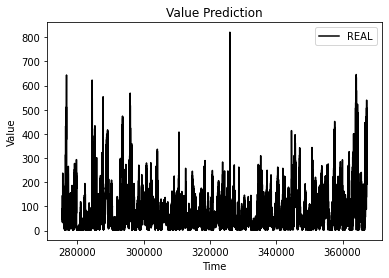

In [21]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

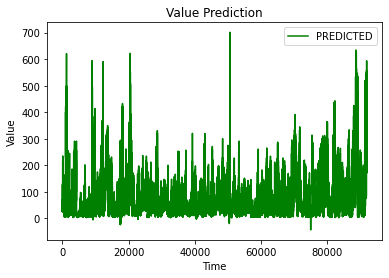

In [22]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [23]:
## Save Model
# model.save('Models/pm25_model.h5')

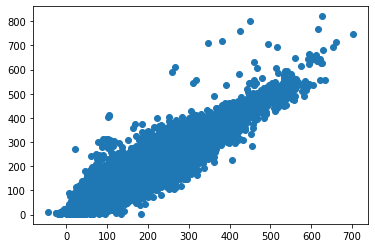

In [24]:
plt.scatter(y_predicted, y_real)

## Create Time Series Models for each variable

array([[<AxesSubplot:title={'center':'PM2.5'}>,
        <AxesSubplot:title={'center':'dt'}>,
        <AxesSubplot:title={'center':'PM10'}>],
       [<AxesSubplot:title={'center':'SO2'}>,
        <AxesSubplot:title={'center':'NO2'}>,
        <AxesSubplot:title={'center':'CO'}>],
       [<AxesSubplot:title={'center':'O3'}>,
        <AxesSubplot:title={'center':'TEMP'}>,
        <AxesSubplot:title={'center':'PRES'}>],
       [<AxesSubplot:title={'center':'DEWP'}>,
        <AxesSubplot:title={'center':'RAIN'}>, <AxesSubplot:>]],
      dtype=object)

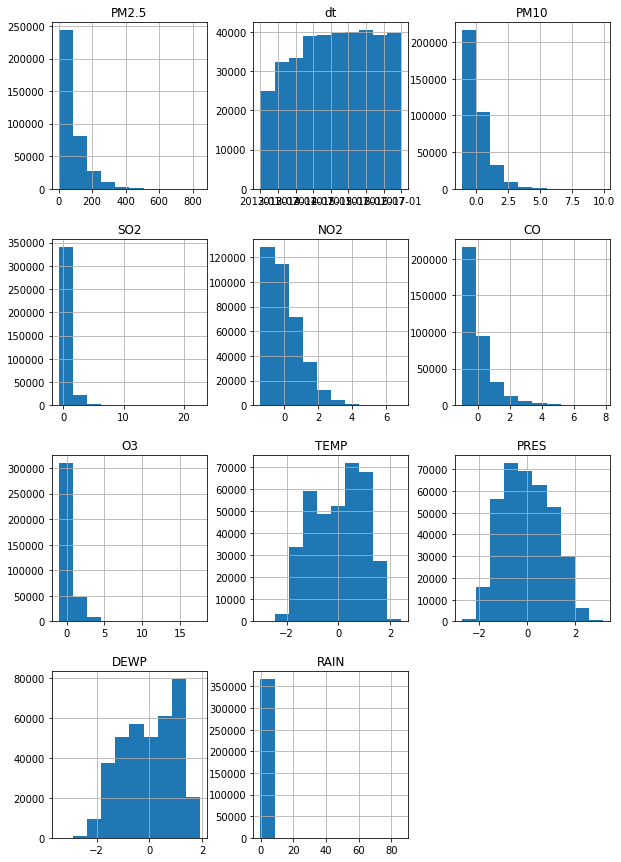

In [25]:
df.hist(figsize=(10, 15))

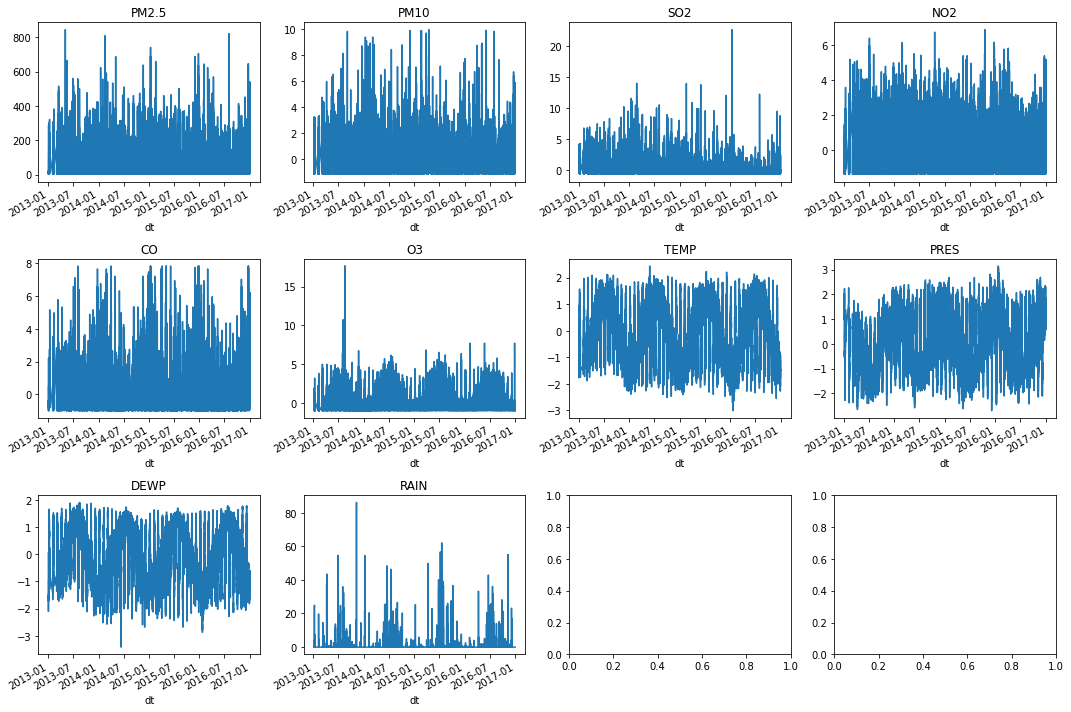

In [26]:
df=df.set_index(pd.to_datetime(df['dt']))
df = df.drop(columns = ['dt'])
fig, ax=plt.subplots(3, 4, figsize=(15, 10))

for idx, each_col in enumerate(df.columns): 
    if idx>=10: 
        break
    row_idx=idx//4
    col_idx=idx%4
    df[each_col].plot(ax=ax[row_idx][col_idx])
    ax[row_idx][col_idx].set_title(each_col)
plt.tight_layout()

In [27]:
df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN
dt,,,,,,,,,,
2013-01-03,4.0,-1.117062,-0.538590,-1.247505,-0.815927,0.330797,-1.309452,1.225754,-1.611258,-0.080522
2013-01-03,9.0,-1.061450,-0.585388,-0.959695,-0.815927,0.539777,-1.291730,1.370984,-1.802370,-0.080522
2013-01-03,4.0,-1.117062,-0.070608,-0.873352,-0.815927,0.191476,-1.309452,1.225754,-1.611258,-0.080522
2013-01-03,7.0,-1.083694,-0.585388,-1.391410,-0.994152,0.574608,-1.451230,0.964339,-1.750917,-0.080522
2013-01-03,5.0,-1.005838,-0.538590,-1.103600,-0.905040,0.470117,-1.291730,1.370984,-1.802370,-0.080522


<AxesSubplot:xlabel='dt'>

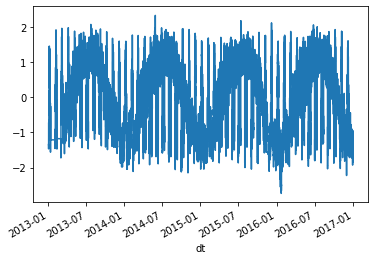

In [28]:
df['TEMP'].rolling(30).median().plot()

In [29]:
grouped_df=df.groupby('dt').mean()
grouped_df['TEMP'].head()

dt
2013-01-03 00:00:00   -1.325402
2013-01-03 01:00:00   -1.337020
2013-01-03 02:00:00   -1.403971
2013-01-03 03:00:00   -1.410469
2013-01-03 04:00:00   -1.447685
Name: TEMP, dtype: float64

### Create SO2 timeseries

In [30]:
import math
temp_arr=grouped_df['SO2'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(25068, 1)

In [31]:
test_arr.shape

(8355, 1)

In [32]:
days_season = 365
X_train = []
y_train = []
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [33]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(24703, 365, 1)

In [34]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(7990, 365, 1)

In [35]:
## So one big array with 365 smaller arrays within, each with 8000 or so individual single-value arrays within 

In [36]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 365, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [37]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
772/772 [==============================] - 303s 386ms/step - loss: 0.1068 - mean_squared_error: 0.1068
Epoch 2/5
772/772 [==============================] - 299s 387ms/step - loss: 0.0596 - mean_squared_error: 0.0596
Epoch 3/5
772/772 [==============================] - 299s 387ms/step - loss: 0.0591 - mean_squared_error: 0.0591
Epoch 4/5
772/772 [==============================] - 302s 391ms/step - loss: 0.0589 - mean_squared_error: 0.0589
Epoch 5/5
772/772 [==============================] - 302s 392ms/step - loss: 0.0592 - mean_squared_error: 0.0592


In [38]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

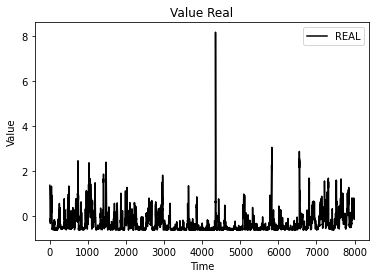

In [39]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Real')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

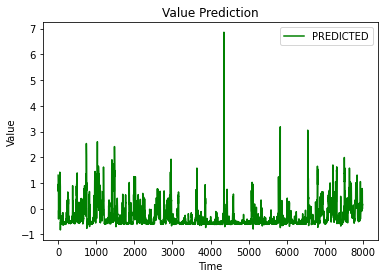

In [40]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [41]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
250/250 [==============================] - 92s 369ms/step - loss: 0.0215 - mean_squared_error: 0.0215
Epoch 2/2
250/250 [==============================] - 89s 358ms/step - loss: 0.0212 - mean_squared_error: 0.0212


In [42]:
## Save Model
# lstm_model.save('Models/so3_model.h5')

### Create CO Time Series Model

In [43]:
temp_arr=grouped_df['CO'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(25068, 1)

In [44]:
test_arr.shape

(8355, 1)

In [45]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [46]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(24703, 365, 1)

In [47]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(7990, 365, 1)

In [48]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 365, 50)           10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [49]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
772/772 [==============================] - 304s 388ms/step - loss: 0.1061 - mean_squared_error: 0.1061
Epoch 2/5
772/772 [==============================] - 292s 378ms/step - loss: 0.0659 - mean_squared_error: 0.0659
Epoch 3/5
772/772 [==============================] - 293s 380ms/step - loss: 0.0651 - mean_squared_error: 0.0651
Epoch 4/5
772/772 [==============================] - 295s 381ms/step - loss: 0.0649 - mean_squared_error: 0.0649
Epoch 5/5
772/772 [==============================] - 291s 377ms/step - loss: 0.0632 - mean_squared_error: 0.0632


In [50]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

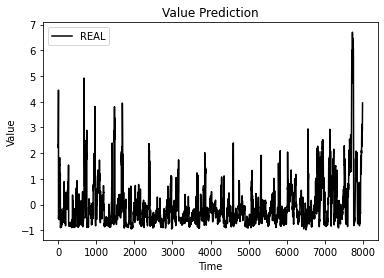

In [51]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

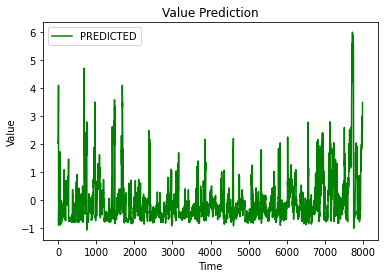

In [52]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [53]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
250/250 [==============================] - 94s 378ms/step - loss: 0.0455 - mean_squared_error: 0.0455
Epoch 2/2
250/250 [==============================] - 96s 385ms/step - loss: 0.0450 - mean_squared_error: 0.0450


In [54]:
## Save Model
# lstm_model.save('Models/co_model.h5')

### Create DEWP Time Series Model

In [55]:
temp_arr=grouped_df['DEWP'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(25068, 1)

In [56]:
test_arr.shape

(8355, 1)

In [57]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [58]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(24703, 365, 1)

In [59]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(7990, 365, 1)

In [60]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 365, 50)           10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_8 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [61]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
772/772 [==============================] - 299s 382ms/step - loss: 0.0408 - mean_squared_error: 0.0408
Epoch 2/5
772/772 [==============================] - 298s 386ms/step - loss: 0.0199 - mean_squared_error: 0.0199
Epoch 3/5
772/772 [==============================] - 290s 375ms/step - loss: 0.0195 - mean_squared_error: 0.0195
Epoch 4/5
772/772 [==============================] - 291s 377ms/step - loss: 0.0195 - mean_squared_error: 0.0195
Epoch 5/5
772/772 [==============================] - 292s 378ms/step - loss: 0.0195 - mean_squared_error: 0.0195


In [62]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

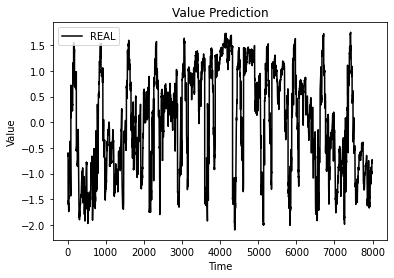

In [63]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

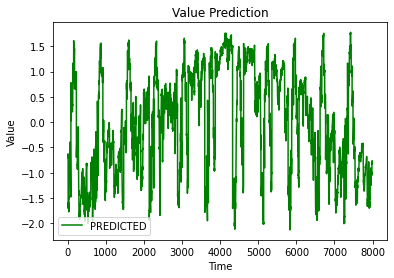

In [64]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [65]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
250/250 [==============================] - 94s 377ms/step - loss: 0.0206 - mean_squared_error: 0.0206
Epoch 2/2
250/250 [==============================] - 91s 363ms/step - loss: 0.0206 - mean_squared_error: 0.0206


In [66]:
## Save Model
# lstm_model.save('Models/dewp_model.h5')

### Create NO2 Time Series Model

In [67]:
temp_arr=grouped_df['NO2'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(25068, 1)

In [68]:
test_arr.shape

(8355, 1)

In [69]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [70]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(24703, 365, 1)

In [71]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(7990, 365, 1)

In [72]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 365, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_10 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [73]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
772/772 [==============================] - 292s 371ms/step - loss: 0.0945 - mean_squared_error: 0.0945
Epoch 2/5
772/772 [==============================] - 241s 312ms/step - loss: 0.0567 - mean_squared_error: 0.0567
Epoch 3/5
772/772 [==============================] - 181s 234ms/step - loss: 0.0555 - mean_squared_error: 0.0555
Epoch 4/5
772/772 [==============================] - 172s 222ms/step - loss: 0.0543 - mean_squared_error: 0.0543
Epoch 5/5
772/772 [==============================] - 173s 224ms/step - loss: 0.0533 - mean_squared_error: 0.0533


In [74]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

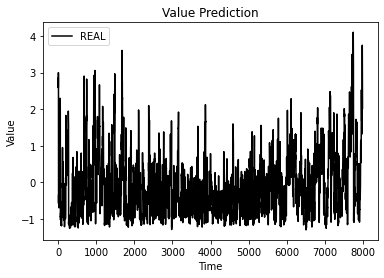

In [75]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

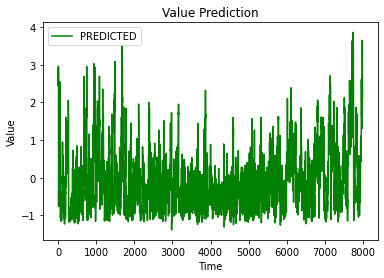

In [76]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [77]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
250/250 [==============================] - 57s 230ms/step - loss: 0.0451 - mean_squared_error: 0.0451
Epoch 2/2
250/250 [==============================] - 58s 232ms/step - loss: 0.0450 - mean_squared_error: 0.0450


In [78]:
## Save Model
# lstm_model.save('Models/no2_model.h5')

### Create O3 time series model

In [79]:
temp_arr=grouped_df['O3'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(25068, 1)

In [80]:
test_arr.shape

(8355, 1)

In [81]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [82]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(24703, 365, 1)

In [83]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(7990, 365, 1)

In [84]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 365, 50)           10400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_12 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [85]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
772/772 [==============================] - 224s 287ms/step - loss: 0.0684 - mean_squared_error: 0.0684
Epoch 2/5
772/772 [==============================] - 226s 293ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 3/5
772/772 [==============================] - 214s 277ms/step - loss: 0.0309 - mean_squared_error: 0.0309
Epoch 4/5
772/772 [==============================] - 219s 284ms/step - loss: 0.0305 - mean_squared_error: 0.0305
Epoch 5/5
772/772 [==============================] - 200s 259ms/step - loss: 0.0302 - mean_squared_error: 0.0302


In [86]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

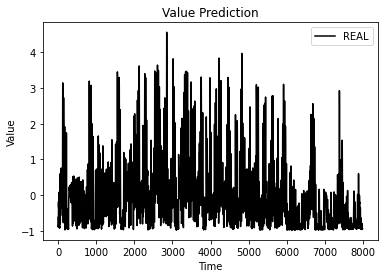

In [87]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

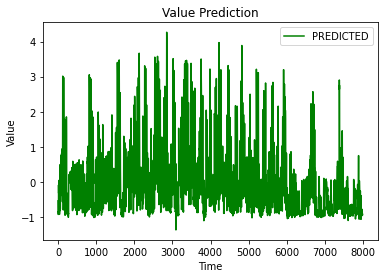

In [88]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [89]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
250/250 [==============================] - 71s 284ms/step - loss: 0.0243 - mean_squared_error: 0.0243
Epoch 2/2
250/250 [==============================] - 61s 245ms/step - loss: 0.0243 - mean_squared_error: 0.0243


In [90]:
## Save Model
# lstm_model.save('Models/o3_model.h5')

### Create pm10 time series model

In [91]:
temp_arr=grouped_df['PM10'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(25068, 1)

In [92]:
test_arr.shape

(8355, 1)

In [93]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [94]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(24703, 365, 1)

In [95]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(7990, 365, 1)

In [96]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 365, 50)           10400     
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_14 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [97]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
772/772 [==============================] - 199s 255ms/step - loss: 0.1178 - mean_squared_error: 0.1178
Epoch 2/5
772/772 [==============================] - 196s 253ms/step - loss: 0.0726 - mean_squared_error: 0.0726
Epoch 3/5
772/772 [==============================] - 201s 260ms/step - loss: 0.0728 - mean_squared_error: 0.0728
Epoch 4/5
772/772 [==============================] - 207s 269ms/step - loss: 0.0723 - mean_squared_error: 0.0723
Epoch 5/5
772/772 [==============================] - 195s 252ms/step - loss: 0.0718 - mean_squared_error: 0.0718


In [98]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

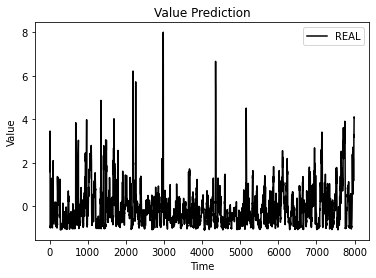

In [99]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

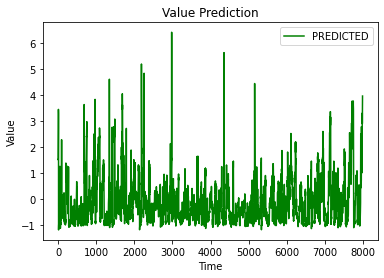

In [100]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [101]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
250/250 [==============================] - 59s 234ms/step - loss: 0.0719 - mean_squared_error: 0.0719
Epoch 2/2
250/250 [==============================] - 56s 223ms/step - loss: 0.0732 - mean_squared_error: 0.0732


In [102]:
## Save Model
# lstm_model.save('Models/pm10_model.h5')

### Create PRES time series model

In [103]:
temp_arr=grouped_df['PRES'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(25068, 1)

In [104]:
test_arr.shape

(8355, 1)

In [105]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [106]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(24703, 365, 1)

In [107]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(7990, 365, 1)

In [108]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 365, 50)           10400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_16 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
624/772 [=======================>......] - ETA: 38s - loss: 0.0473 - mean_squared_error: 0.0473

In [ ]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

In [ ]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

In [ ]:
## Save Model
# lstm_model.save('Models/pres_model.h5')

### Create TEMP time series model

In [ ]:
temp_arr=grouped_df['TEMP'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

In [ ]:
test_arr.shape

In [ ]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [ ]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

In [ ]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

In [ ]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

In [ ]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

In [ ]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

In [ ]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

In [ ]:
## Save Model
# lstm_model.save('Models/temp_model.h5')

### Create RAIN time series model

In [ ]:
temp_arr=grouped_df['RAIN'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

In [ ]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [ ]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

In [ ]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

In [ ]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

In [ ]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

In [ ]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

In [ ]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

In [ ]:
## Save Model
# lstm_model.save('Models/rain_model.h5')